In [170]:
import numpy as np
import scipy.stats as scs
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from tqdm import tqdm

# Copula estimation with Scoring Rules

### Creating locations

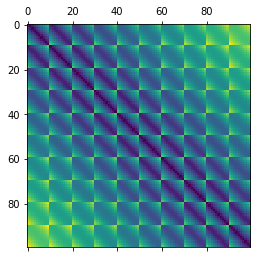

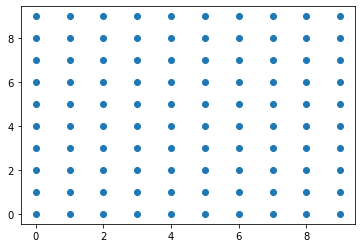

In [129]:
# define x and y ranges and step size
x_range = np.arange(0, 10, step=1)
y_range = np.arange(0, 10, step=1)

# create grid of 2D locations using meshgrid function
xx, yy = np.meshgrid(x_range, y_range)
locations = np.column_stack((xx.ravel(), yy.ravel()))

# create distance matrix
dist_mat = distance_matrix(locations,locations)
plt.matshow(dist_mat)
plt.show()
plt.scatter(locations[:,0],locations[:,1])

### Generating observations for locations

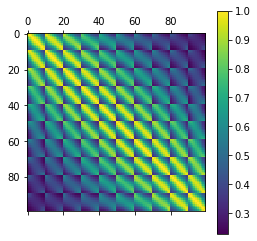

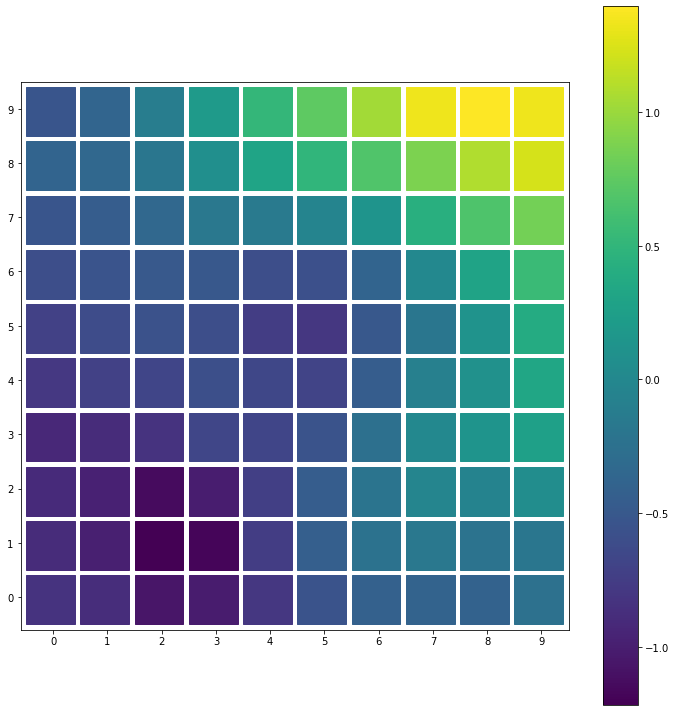

In [159]:
# covariance matrix
true_theta = [33,3]
plt.matshow(Matern(length_scale=true_theta[0], nu=true_theta[1]).__call__(dist_mat))
plt.colorbar()
plt.show()

# generate samples
true_cov = Matern(length_scale=true_theta[0], nu=true_theta[1]).__call__(dist_mat)
obs = scs.multivariate_normal.rvs(mean=np.zeros(100), cov=true_cov, size=1000)

# create plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_xticks(x_range)
ax.set_yticks(y_range)

# define colormap
cmap = plt.cm.get_cmap('viridis')

# plot locations as colored rectangles
for i, loc in enumerate(locations):
    x, y = loc
    color = cmap((obs[0, i] - obs[0].min()) / (obs[0].max() - obs[0].min()))
    ax.add_patch(plt.Rectangle((x-0.5, y-0.5), 0.9, 0.9, fill=True, color=color))

# add colorbar
norm = plt.Normalize(vmin=obs[0].min(), vmax=obs[0].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)

plt.xlim(-0.6,9.5)
plt.ylim(-0.6,9.5)
plt.tight_layout()
plt.show()

### Scoring Rule

In [174]:
from scipy.spatial.distance import pdist

def Spatial_Energy_Score(beta,observations_y,simulations_Y):

    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = np.array(observations_y)
    simulations_Y = np.array(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = np.power(
            np.linalg.norm(
                np.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * np.power(
        pdist(simulations_Y)
    ,beta)

    Energy = 2 * np.mean(diff_Y_y) - np.sum(diff_Y_Y)/(m*(m-1))
    return Energy

def SR_eval(theta,beta,obs,D):
    sims = scs.multivariate_normal.rvs(mean=np.zeros(100), cov=Matern(length_scale=theta[0], nu=theta[1]).__call__(D), size=1000)
    out = 0
    for row in tqdm(obs):
        out+= Spatial_Energy_Score(beta,row,sims)
    return out/len(obs)

In [175]:
SR_eval([33,33],1,obs[:500],dist_mat)

100%|██████████| 500/500 [00:15<00:00, 32.07it/s]


13.317681706994364

In [186]:
t = []
for k in range(1,50):
    t.append(SR_eval([k,33],0.2,obs,dist_mat))

100%|██████████| 1000/1000 [00:40<00:00, 24.55it/s]


In [185]:
t[28]-t[33]

-0.0009360790176546896

In [184]:
np.argmin(t)

28

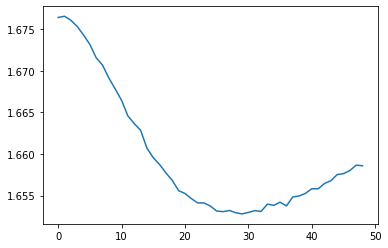

In [189]:
plt.plot(t) # beta=0.2
import pickle
with open('SR_values.txt','wb') as f:
    pickle.dump(t,f)

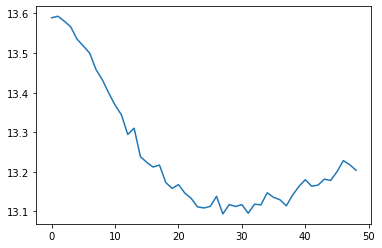

In [177]:
plt.plot(t) # beta=1